## Prepare the Data

In [1]:
import string

ascii_letters = string.ascii_letters + " "
n_ascii_letters = len(ascii_letters)

pos_words = {}
poss = []
n_poss = 0

In [2]:
def keep_letters(word):
    for char in word:
        if char not in ascii_letters:
            return ""
    return word

In [3]:
def collect_words(file):
    with open(file, encoding="utf-8") as f:
        file_data = f.read()
    
    # Splits the file.
    words = file_data.split()
    # Keeps only letters.
    words = [keep_letters(word) for word in words]
    # Removes empty string
    words = [word for word in words if word != ""]
    
    return words

In [4]:
import os
import glob

for file in glob.glob("data_/pos_words/*"):
    pos = os.path.splitext(os.path.basename(file))[0]
    words = collect_words(file)
    
    pos_words[pos] = words
    
poss = list(pos_words.keys())
n_poss = len(poss)

## Build the Model.

In [5]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_poss + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_poss + input_size + hidden_size, output_size)
        
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, pos, input_, hidden):
        input_combined = torch.cat((pos, input_, hidden), dim=1)
        
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        
        output_combined = torch.cat((hidden, output), dim=1)
        
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
rnn = RNN(n_ascii_letters, 128, n_ascii_letters)

# Loss Function

In [7]:
loss_function = nn.NLLLoss()

# Optimizer

In [8]:
import torch.optim as optim

optimizer = optim.SGD(rnn.parameters(), lr=0.008)

# Train the Model

In [9]:
n_iter = 100_000

display_every = 5_000
plot_every = 1_000
losses = []

In [10]:
import random

def random_choose(list_):
    random_idx = random.randint(0, len(list_) - 1)
    return list_[random_idx]

In [11]:
def pos_2_tensor(pos):
    tensor = torch.zeros(1, n_poss)
    
    idx = poss.index(pos)
    tensor[0][idx] = 1
    
    return tensor

In [12]:
def input_2_tensor(input_):
    tensor = torch.zeros(len(input_), 1, n_ascii_letters)
    
    for i in range(len(input_)):
        char = input_[i]
        tensor[i][0][ascii_letters.index(char)] = 1
        
    return tensor

In [13]:
def target_2_tensor(target):
    idxs = [ascii_letters.index(char) for char in target[1:]]
    idxs.append(n_ascii_letters - 1)
    
    return torch.tensor(idxs, dtype=torch.long).unsqueeze_(-1)

In [14]:
def random_training_example():
    pos = random_choose(poss)
    word = random_choose(pos_words[pos])
    
    pos_tensor = pos_2_tensor(pos)
    input_tensor = input_2_tensor(word)
    target_tensor = target_2_tensor(word)
    
    return pos_tensor, input_tensor, target_tensor

In [15]:
def train(pos, input_, target):
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    
    loss = 0
    for i in range(len(input_)):
        # Forward.
        output, hidden = rnn(pos, input_[i], hidden)
        
        loss_ = loss_function(output, target[i])
        loss += loss_
    
    # Backward.
    loss.backward()
    
    # Updates params.
    optimizer.step()
    
    return output, loss / len(input_)

In [16]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    plt.plot(losses)
    plt.show()

iteration:   5000 (  5%), loss: 3.728240
iteration:  10000 ( 10%), loss: 3.014575
iteration:  15000 ( 15%), loss: 2.239202
iteration:  20000 ( 20%), loss: 1.098354
iteration:  25000 ( 25%), loss: 1.111992
iteration:  30000 ( 30%), loss: 1.693288
iteration:  35000 ( 35%), loss: 1.746204
iteration:  40000 ( 40%), loss: 0.863328
iteration:  45000 ( 45%), loss: 0.775152
iteration:  50000 ( 50%), loss: 1.617211
iteration:  55000 ( 55%), loss: 3.845424
iteration:  60000 ( 60%), loss: 2.269430
iteration:  65000 ( 65%), loss: 1.080203
iteration:  70000 ( 70%), loss: 2.563140
iteration:  75000 ( 75%), loss: 1.093729
iteration:  80000 ( 80%), loss: 1.026425
iteration:  85000 ( 85%), loss: 0.759589
iteration:  90000 ( 90%), loss: 2.334222
iteration:  95000 ( 95%), loss: 2.392083
iteration: 100000 (100%), loss: 2.751054


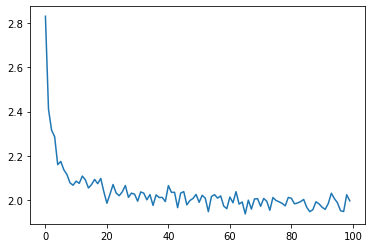

In [17]:
running_loss = 0

for iteration in range(1, n_iter + 1):
    # Prepare data.
    pos, input_, target = random_training_example()

    # Training.
    _, loss = train(pos, input_, target)
    
    # Tracks the training process.
    if iteration % display_every == 0:
        print(f"iteration: {iteration:>6} ({iteration / n_iter:>4.0%}), loss: {loss:.6f}")
        
    running_loss += loss
    if iteration % plot_every == 0:
        losses.append(running_loss / plot_every)
        running_loss = 0
        
plot_losses(losses)

## Test the Model

In [18]:
max_length = 30

In [187]:
def sample(pos, start_letter="a"):
    pos = pos_2_tensor(pos)
    input_ = input_2_tensor(start_letter)
    hidden = rnn.init_hidden()
    
    word = start_letter
    
    for i in range(max_length):
        output, hidden = rnn(pos, input_[0], hidden)  # not output, _
        
        top_values, top_idxs = output.topk(1)
        top_idx = top_idxs[0][0]
        
        if top_idx == n_ascii_letters - 1:
            break
        else:
            char = ascii_letters[top_idx]
            word += char
            
        input_ = input_2_tensor(char)
        
    return word

In [194]:
print(sample("ADJ", "o"))
print(sample("ADV", "t"))
print(sample("NOUN", "t"))
print(sample("VERB", "f"))

ored
taringly
torich
furd
